In [1]:
using PyCall
using Plots
using Mmap
import SpecialFunctions

In [2]:
function estendermodelo(vel,borda,topbc)
    (nz,nx)=size(vel)
    nxa=nx+2*borda
    if topbc == "abbc"
        nza=nz+2*borda
        modelo=zeros(eltype(vel),nza,nxa)
        modelo[borda+1:borda+nz,borda+1:borda+nx]=vel
        recheio=vel[:,1]
        for i=1:borda
            modelo[borda+1:borda+nz,i].=recheio
        end
        recheio=vel[:,nx]
        for i=borda+nx+1:nxa
            modelo[borda+1:borda+nz,i].=recheio
        end
        recheio=modelo[borda+nz,:]
        for i=borda+nz+1:nza
            modelo[i,:].=recheio
        end
        recheio=modelo[borda+1,:]
        for i=1:borda
            modelo[i,:].=recheio
        end
    elseif topbc == "free"
        nza=nz+borda
        modelo=zeros(eltype(vel),nza,nxa)
        modelo[1:nz,borda+1:borda+nx]=vel
        recheio=vel[:,1]
        for i=1:borda
            modelo[1:nz,i].=recheio
        end
        recheio=vel[:,nx]
        for i=borda+nx+1:nxa
            modelo[1:nz,i].=recheio
        end
        recheio=modelo[nz,:]
        for i=nz:nza
            modelo[i,:].=recheio
        end
    end
    return modelo
end

function taper(nz, nx, borda, topbc)
    nxa=nx+2*borda
    nza=nz+2*borda
    amortece=ones(nza,nxa)
    for j=1:nxa
        if topbc == "abbc"
            for i=1:borda
                amortece[i,j]=amortece[nza-i+1,j]=exp(-(0.3*(borda-i)/borda)^2)
            end
        elseif topbc == "free"
            for i=1:borda
                amortece[nza-i+1,j]=exp(-(0.3*(borda-i)/borda)^2)
            end
        end
    end
    for j=1:borda
        for i=1:nza
            amortece[i,j]=amortece[i,nxa-j+1]=exp(-(0.3*(borda-j)/borda)^2)
        end
    end
    return amortece
end

taper (generic function with 1 method)

In [3]:
function GeologicalModel(cp_model, cs_model, ro_model, n1, borda)
    
    geo = Dict("nx"=>0, "nz"=>0, "dx"=>0, "dz"=>0,
                "cp"=>0, "cs" =>0,"rho" =>0, "lambda" => 0,
                "mu"=>0, "topbc"=>"free", "sidesbc"=>"abbc")
    
    # Lendo o modelo de velocidade
    if isfile(cp_model)
        saida=Mmap.mmap(cp_model,Vector{Float32})
        n2=length(saida)÷n1
        velP=reshape(saida,n1,n2)[:,:]
    else
        error("O arquivo $cp_model não existe")
    end
    
    if isfile(ro_model)
        saida=Mmap.mmap(cs_model,Vector{Float32})
        n2=length(saida)÷n1
        velS=reshape(saida,n1,n2)[:,:]
    else
        error("O arquivo $ro_model não existe")
    end
    
    # Lendo o modelo de densidade
    if isfile(ro_model)
        saida=Mmap.mmap(ro_model,Vector{Float32})
        n2=length(saida)÷n1
        dens=reshape(saida,n1,n2)[:,:]
    else
        error("O arquivo $ro_model não existe")
    end
    
    # Adicionando extensão de amortecimento
    cp = estendermodelo(velP,borda,geo["topbc"])
    cs = estendermodelo(velS,borda,geo["topbc"])
    rho = estendermodelo(dens,borda,geo["topbc"])

    # Computando as demais propriedades da geologia
    geo["cp"] = zeros(size(cp))
    geo["cs"] = zeros(size(cs))
    geo["rho"] = zeros(size(rho))
    geo["cp"] .= cp
    geo["cs"] .= cs
    geo["rho"] .= rho

    geo["dx"] = geo["dz"] = 5.0
    geo["nz"], geo["nx"] = size(cp)

    geo["mu"] = geo["cs"] .* geo["cs"] .* geo["rho"]
    geo["lambda"] = geo["cp"] .* geo["cp"] .* geo["rho"]  .- 2*geo["mu"]

    return geo
end

GeologicalModel (generic function with 1 method)

Geological Model Created


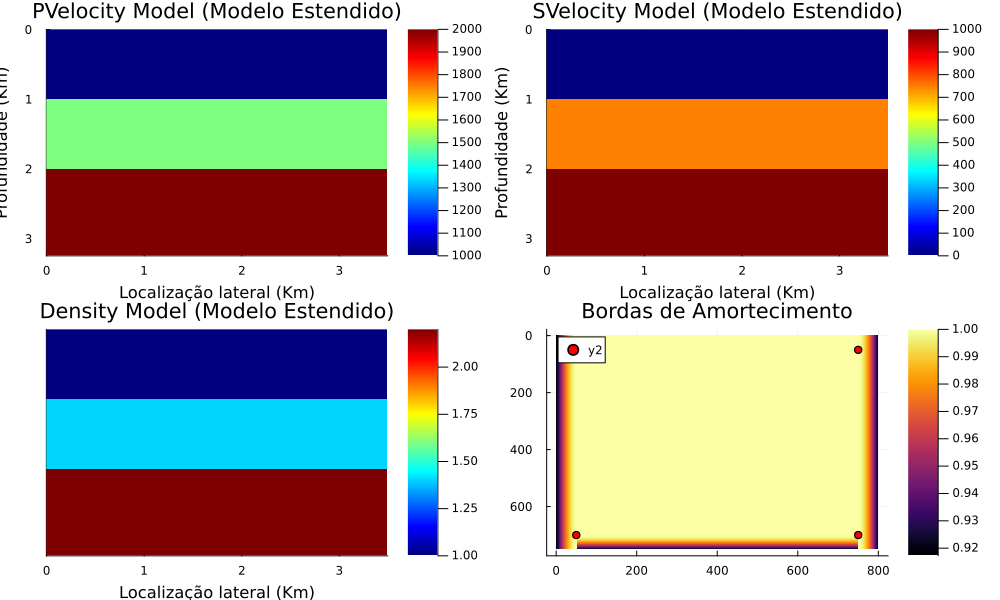

In [4]:
# Criando o modelo geológico (Homogêneo, heterogênio ou importado)

borda=50
cpbin= "C:/Users/Matheus/Trabalhos e Estudos/Trabalhos para o mestrado/GeologicalData/cp_heto3.bin"
csbin = "C:/Users/Matheus/Trabalhos e Estudos/Trabalhos para o mestrado/GeologicalData/cs_heto3.bin"
robin = "C:/Users/Matheus/Trabalhos e Estudos/Trabalhos para o mestrado/GeologicalData/rho_heto3.bin"

model_geological = GeologicalModel(cpbin, csbin, robin, 600, borda)
println("Geological Model Created")

nx = model_geological["nx"]
nz = model_geological["nz"]
dx = model_geological["dx"]
dz = model_geological["dz"]

x = (0:dx:(nx-1)*dx)/1000
z = (0:dz:dz*(nz-1))/1000

ret_x=[borda,borda+nx,borda+nx,borda,borda]
ret_z=[borda,borda,borda+nz,borda+nz,borda]
amortecedor = taper(nz, nx, borda, model_geological["topbc"])

p1 = heatmap(range(x[1], stop=x[end], length=length(x)), range(z[1], stop=z[end], length=length(z)), model_geological["cp"],
    axis=:on, color=:auto,c=:jet, title="PVelocity Model (Modelo Estendido)", yflip=true, xlabel="Localização lateral (Km)", ylabel="Profundidade (Km)")

p2 = heatmap(range(x[1], stop=x[end], length=length(x)), range(z[1], stop=z[end], length=length(z)), model_geological["cs"],
    axis=:on, color=:auto,c=:jet, title="SVelocity Model (Modelo Estendido)", yflip=true, xlabel="Localização lateral (Km)", ylabel="Profundidade (Km)")

p3 = heatmap(range(x[1], stop=x[end], length=length(x)), range(z[1], stop=z[end], length=length(z)), model_geological["rho"], 
    axis=:on, color=:auto,c=:jet, title="Density Model (Modelo Estendido)", yflip=true, xlabel="Localização lateral (Km)", yticks=false)

p4 = heatmap(amortecedor, title="Bordas de Amortecimento", yflip=true)
scatter!(ret_x,ret_z, color=:red)

plot(p1, p2, p3, p4, layout=(2,2), size=(1000, 600))

In [5]:
function wavelet(f_corte, t)

    f_c = f_corte/(3*sqrt(pi))
    t_0 = (2*sqrt(pi))/f_corte
    t_d = t .- t_0

    src = -(2*pi^3 .*(f_c .*t_d).^2 .- 1) .* exp.(-(pi^3 .*(f_c .*t_d).^2))
    return src
end

wavelet (generic function with 1 method)

wavelet Created


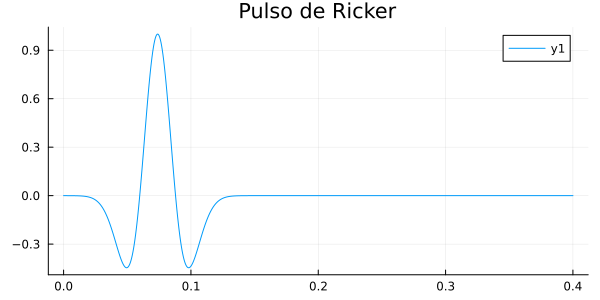

In [6]:
# Criando a assinatura sísmica (Pulso de Ricker)

dt = 0.0005
nt = 600
t = 0:dt:nt*dt
f_corte = 48

source = wavelet(f_corte, t)
println("wavelet Created")

plot(t, source, title="Pulso de Ricker", label=false, size=(600, 300), xlabel="tempo (s)", ylabel="Amplitude")

In [7]:
function diffvelocity(txx, tzz, txz, vx, vz, dt, dx, dz, rho, topbc)

    # Coeficientes da aproximção por diferenças finitas
    g1 = -1/24
    g2 = 9/8
    
    dtdx = dt/dx
    dtdz = dt/dz
    
    bxx0 = bzz0 = rho[1,1]
    
    for i=3:nx-1
        for k=3:nz-1
            
            bzz = 0.5 * (1/rho[k - 1, i] + 1/rho[k, i])
            bxx = 0.5 * (1/rho[k, i - 1] + 1/rho[k, i])
            
            vx[k, i] = vx[k, i] + dtdx * bxx * (
                g1 * (txx[k, i + 1] - txx[k, i - 2]) + g2 * (txx[k, i] - txx[k, i - 1]) +
                g1 * (txz[k + 2, i] - txz[k - 1, i]) + g2 * (txz[k + 1, i] - txz[k, i]))

            vz[k, i] = vz[k, i] + dtdz * bzz * (
                g1 * (txz[k, i + 2] - txz[k, i - 1]) + g2 * (txz[k, i + 1] - txz[k, i]) +
                g1 * (tzz[k + 1, i] - tzz[k - 2, i]) + g2 * (tzz[k, i] - tzz[k - 1, i]))
            
        end
    end
    
    for i=3:nx-1
        bxx = 0.5 * (1/rho[2, i - 1] + 1/rho[2, i])
        vx[2,i] = vx[2,i] + dtdx * bxx *(g1*(txx[2, i+1]-txx[2, i-2]) +
                g2*(txx[2, i]-txx[2, i-1])+ g1*(txz[4, i]-txz[1, i]) +
                g2*(txz[3, i]-txz[2, i]))
    end
    
    for k=3:nz-1
        bzz = 0.5 * (1/rho[k, 2] + 1/rho[k-1, 2])
        vz[k,2] = vz[k,2] + dtdz * bzz*(g1*(txz[k,4]-txz[k,1])+
                g2*(txz[k,3]-txz[k,2])+ g1*(tzz[k+1,2]-tzz[k-2,2])+ 
                g2*(tzz[k,2]-tzz[k-1,2]))
    end
    
    if topbc == "free"
        for il=3:nx-1
            vx[1, il] = vx[1, il] + dtdx *  bxx0 * (g1 * (txx[1, il + 1] - txx[1, il - 2]) +
                                            g2 * (txx[1, il] - txx[1, il - 1]) +
                                            g1 * (txz[3, il] + txz[2, il]) +
                                            g2 * (txz[2, il] - txz[1, il]))
        end
        for im=2:nx-1
            vz[1, im] = vz[1, im] + 2 * dtdz * bzz0 * (g1 * tzz[2, im] + g2 * tzz[1, im])
            vz[2, im] = vz[2, im] + dtdz * bzz0 * (g1 * (tzz[3, im] + tzz[1, im]) +
                                        g2 * (tzz[2, im] - tzz[1, im]) +
                                        g1 * (txz[2, im + 2] - txz[2, im - 1]) +
                                        g2 * (txz[2, im + 1] - txz[2, im]))
        end   
    end
end

function diffstrain(txx, tzz, txz, vx, vz, dt, dx, dz, elastic_mo, topbc)
    
    # Coeficientes da aproximção por diferenças finitas
    g1 = -1/24
    g2 = 9/8
    
    dtdx = dt/dx
    dtdz = dt/dz
    
    for i=2:nx-1
        for k=3:nz-1
            
            C55 = (0.25*(1/elastic_mo[5,5,k,i] + 1/elastic_mo[5,5,k,i-1] + 1/elastic_mo[5,5,k,i] + 1/elastic_mo[5,5,k-1,i]))^(-1)

            exx = g1 * (vx[k, i + 2] - vx[k, i - 1]) + g2 * (vx[k, i + 1] - vx[k, i])
            ezz = g1 * (vz[k + 2, i] - vz[k - 1, i]) + g2 * (vz[k + 1, i] - vz[k, i])
            
            if i == 2  
                exz = g1*(vx[k+1, 2] - vx[k-2, 2]) + g2*(vx[k, 2]-vx[k-1, 2]) + vz[k, 2] - vz[k, 1];   
            elseif i > 2      
                exz = g1 * (vx[k + 1, i] - vx[k - 2, i]) + g2 * (vx[k, i] - vx[k - 1, i]) +
                      g1 * (vz[k, i + 1] - vz[k, i - 2]) + g2 * (vz[k, i] - vz[k, i - 1])      
            end
            
            if k == nz-1   
                if i == 2 
                    exz = vx[k,2] - vx[k-1,i] + vz[k,i] - vz[k,i]
                elseif i > 2 
                    exz = vx[k,i]- vx[k-1,i] + g1*(vz[k,i+1] - vz[k,i-2]) + g2*(vz[k,i]-vz[k,i-1])
                end          
            end
            
            txx[k, i] = txx[k, i] + dtdx * (elastic_mo[1,1,k,i] * exx[1] +  elastic_mo[1,3,k,i] * ezz[1])
            tzz[k, i] = tzz[k, i] + dtdz * (elastic_mo[3,1,k,i] * exx[1] +  elastic_mo[3,3,k,i] * ezz[1])
            txz[k, i] = txz[k, i] + dtdx * C55 * exz[1]
        
        end
    end

    if topbc == "free" # Free surface boundary conditions
        
        for il=3:nx-1
            C55 = (0.25*(1/elastic_mo[5,5,2,il] + 1/elastic_mo[5,5,1,il] + 1/elastic_mo[5,5,2,il] + 1/elastic_mo[5,5,2,il-1]))^(-1)
            txz[1, il] = 0
            txz[2, il] = txz[2, il] + dtdx * C55 * (g1 * (vx[3, il] + vz[1, il-1] - vz[1,il] - vx[1,il]) + 
                                    g2 * (vx[2, il] - vx[1,il]) + 
                                    g1 * (vz[2,il+1] - vz[2,il-2]) + 
                                    g2 * (vz[2, il] - vz[2, il-1]))
        end
        
        for im=2:nx
            tzz[1, im] = tzz[1, im] + dtdz * elastic_mo[3,1,1,im] * (g1 * (vx[1,im+2] - vx[1,im-1]) + g2 * (vx[1, im+1] - vx[1,im])) + 
                        dtdx * elastic_mo[3,3,1,im] * (vz[2, im] - vz[1, im])

            tzz[2, im] = tzz[2, im] + dtdz * elastic_mo[3,1,2,im] * (g1 * (vx[2, im+2] - vx[2, im-1]) + g2 * (vx[2, im+1] - vx[2, im])) + 
                        dtdx * elastic_mo[3,3,2,im] * (g1 * (vz[4, im] - vz[1,im]) + g2 * (vz[3, im] - vz[2, im]))
        end
        
        for iq=2:nx
            txx[1, iq] = txx[1, iq]  + dtdx * elastic_mo[1,1,1,iq] * (g1 * (vx[1, iq+2] - vx[1, iq-1]) + g2 * (vx[1,iq+1] - vx[1, iq])) + 
                        dtdx * elastic_mo[1,3,1,iq] * (vz[2, iq] - vz[1, iq])

            txx[2, iq] = txx[2, iq] + dtdx * elastic_mo[1,1,2,iq] * (g1 * (vx[2, iq+2] - vx[2, iq-1]) + g2 * (vx[2, iq+1] - vx[2, iq])) + 
                        dtdx * elastic_mo[1,3,2,iq] * (g1 * (vz[4, iq] - vz[1, iq]) + g2 * (vz[3, iq] - vz[2, iq]))
        end
    end
end

diffstrain (generic function with 1 method)

In [8]:
function WavePropagator(nt, dt, geo, aqui, amortecedor)
    
    dx = geo["dx"]
    dz = geo["dz"]
    nx = geo["nx"]
    nz = geo["nz"]
    
    ixs = aqui["isx"]
    izs = aqui["isz"]
    irx = aqui["irx"]
    irz = aqui["irz"]
    source = aqui["source"]
    topbc = geo["topbc"]
    sidesbc = geo["sidesbc"]

    isoType = aqui["isoType"]

    nrec = length(aqui["irx"])

    SismP = zeros(Float64, nt, nrec)
    SismVx = zeros(Float64, nt, nrec)
    SismVz = zeros(Float64, nt, nrec)

    snap1 = 50
    snapRate = 50
    snapTimes = snap1:snapRate:nt
    pSnap = zeros(Float64, geo["nz"],  geo["nx"], length(snapTimes))
    
    rho = geo["rho"]
    elastic_mo = zeros(6,6,nz,nx)
    
    for i in 1:6
        for j in 1:6
            if i == j && i < 4
                elastic_mo[i, j, :, :] = geo["lambda"] + 2 * geo["mu"]
            elseif i == j && i >= 4
                 elastic_mo[i, j, :, :] = geo["mu"]
            elseif i == 1 && (j == 2 || j == 3)
                 elastic_mo[i, j, :, :] = geo["lambda"] 
            elseif i == 2 && (j == 1 || j == 3)
                 elastic_mo[i, j, :, :] = geo["lambda"] 
            elseif i == 3 && (j == 1 || j == 2)
                 elastic_mo[i, j, :, :] = geo["lambda"] 
            end
        end
    end
    
    eps = 1/24 + 9/8
    if maximum(geo["cp"])*dt/geo["dx"] <= 1/eps

        println("Critério de estabilidade obedecido")
        
        soufac = dt / (dx * dz)
        vx = zeros(Float64,nz+2, nx+2)
        vz = zeros(Float64,nz+2, nx+2)
        txx = zeros(Float64,nz+2, nx+2)
        tzz = zeros(Float64,nz+2, nx+2)
        txz = zeros(Float64,nz+2, nx+2)

        for c1 in 1:nt
            println(c1)
            diffvelocity(txx, tzz, txz, vx, vz, dt, dx, dz, rho, topbc) # Evolução do campo de velocidade
            
            vx[1:nz,1:nx] .= vx[1:nz,1:nx].* amortecedor[1:nz,1:nx]
            vz[1:nz,1:nx] .= vz[1:nz,1:nx].* amortecedor[1:nz,1:nx]
            
            # Adicionando pertubação cisilhante
            
            if isoType == 4
                adds = 0.5 .* soufac .* source[c1] ./ rho
                vx[izs, ixs] .= vx[izs, ixs] .+ adds
                vx[izs + 1, ixs] .= vx[izs + 1, ixs] .+ adds
            end

            if isoType == 3
                adds = 0.5 .* soufac .* source[c1] ./ rho
                vz[izs + 1, ixs - 1] .= vz[izs + 1, ixs - 1] .+ adds
                vz[izs + 1, ixs] .= vz[izs + 1, ixs] .+ adds
            end
                       
            diffstrain(txx, tzz, txz, vx, vz, dt, dx, dz, elastic_mo, topbc) # Evolução do campo de tensão
            
            tzz[1:nz,1:nx] .= tzz[1:nz,1:nx].*amortecedor[1:nz,1:nx]
            txx[1:nz,1:nx] .= txx[1:nz,1:nx].*amortecedor[1:nz,1:nx]
            txz[1:nz,1:nx] .= txz[1:nz,1:nx].*amortecedor[1:nz,1:nx]
            
            # Adicionando pertubação explosiva
            if isoType == 1 
                adds = soufac * source[c1] * 0.25
                adds_matrix = fill(adds, (2, 2))
                txx[izs:izs+1,ixs-1:ixs] .+= adds_matrix
                tzz[izs:izs+1, ixs-1:ixs] .+= adds_matrix
            end

            for i=1:length(irx)
                SismP[c1, i] = 0.5 * (txx[irz, irx[i]] + tzz[irz, irx[i]])
                SismVx[c1, i] = vx[irz,irx[i]]
                SismVz[c1, i] = vz[irz,irx[i]]
            end
        end
    else
        println("Critério de estabilidade não obedecido")
    end
    return pSnap, SismP, SismVx, SismVz
end

WavePropagator (generic function with 1 method)

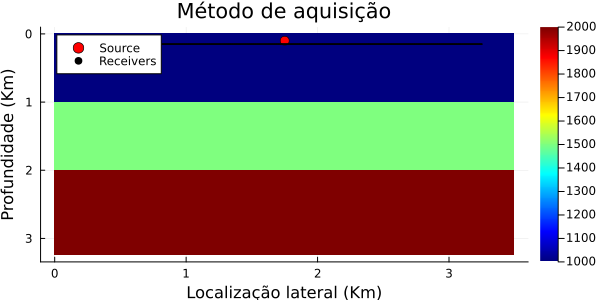

In [9]:
# Característica da aquisição
aqui = Dict("isz" => 20, "irz" => 30, "isx" => 350 , "irx" => borda:1:model_geological["nx"]-borda, "isoType" => 1, "source" => source)

p1 = heatmap(range(x[1], stop=x[end], length=length(x)), range(z[1], stop=z[end], length=length(z)), model_geological["cp"],
    axis=:on, color=:auto,c=:jet, title="Método de aquisição", yflip=true, xlabel="Localização lateral (Km)", ylabel="Profundidade (Km)")
scatter!([dx*aqui["isx"]/1000], [dz*aqui["isz"]/1000], color=:red, markersize=5, label="Source")
scatter!([dx*aqui["irx"]/1000], [dz*aqui["irz"]/1000], color=:black, markersize=1, label="Receivers")
plot(p1, layout=(1,2), size=(600, 300))

In [10]:
# Propagador 2D via método das diferenças finitas

pSnap, SismP, SismVx, SismVz = @time WavePropagator(nt, dt, model_geological, aqui, amortecedor)
println("Finish propagation")

Critério de estabilidade obedecido
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
2

LoadError: InterruptException:

In [11]:
p1 = heatmap(range(x[1], stop=x[end], length=length(x)), range(t[1], stop=t[end-1], length=length(t)-1),
    SismP, axis=:on, color=:auto, colorbar=false,c=:seismic, title="Pfield", yflip=true, 
    xlabel="Localização lateral (Km)", ylabel="Tempo (s)")

p2 = heatmap(range(x[1], stop=x[end], length=length(x)), range(t[1], stop=t[end-1], length=length(t)-1),
    SismVx, axis=:on, color=:auto, colorbar=false,c=:seismic, title="Vxfield", yflip=true, yticks=false,
    xlabel="Localização lateral (Km)")

p3 = heatmap(range(x[1], stop=x[end], length=length(x)), range(t[1], stop=t[end-1], length=length(t)-1),
    SismVz, axis=:on, color=:auto, colorbar=false, c=:seismic, title="Vzfield", yflip=true, yticks=false,
    xlabel="Localização lateral (Km)")

plot(p1, p2, p3, layout=(1,3), size=(800, 400))

LoadError: UndefVarError: `SismP` not defined

In [12]:
anim = @animate for c1 in 1:1:40
    heatmap(range(x[1], stop=x[end], length=length(x)), range(z[1], stop=z[end], length=length(z)), pSnap[:,:,c1],
            c=:seismic, colorbar=false, clim=(minimum(pSnap[:,:,15]), maximum(pSnap[:,:,15])),
            yflip=true, xlabel="Localização lateral (Km)", ylabel="Profundidade (Km)")
    
    # Plotagem dos dados modelados com transparência ajustada
    heatmap!(range(x[1], stop=x[end], length=length(x)), range(z[1], stop=z[end], length=length(z)), model_geological["cp"]/10^11,
            alpha=0.7, axis=:on, color=:auto, c=:Greys, colorbar=false, clim=(minimum(model_geological["cp"]/10^11), maximum(model_geological["cp"]/10^11)), 
            yflip=true, xlabel="Localização lateral (Km)", ylabel="Profundidade (Km)")
    
    # Plotagem dos pontos de interesse (source e receivers)
    scatter!([dx*aqui["isx"]/1000], [dz*aqui["isz"]/1000], color=:red, markersize=5, label="Source")
    scatter!([dx*aqui["irx"]/1000], [dz*aqui["irz"]/1000], color=:black, markersize=1, label="Receivers")
end

gif(anim, "C:/Users/Matheus/Pictures/DadosModelagens/Resultados/PfieldsElasticWaveHeterogenius.gif", fps=20, loop=0, variable_palette=false, verbose=false, show_msg=true)

LoadError: UndefVarError: `pSnap` not defined